<a href="https://colab.research.google.com/github/keqingli1129/AIRAG/blob/main/SmolLM3_LoRA_PFAF750_SFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Fine-Tuning SmolLM3-3B on PFAF750 with LoRA (Colab T4-safe) — v3

This notebook fine-tunes **HuggingFaceTB/SmolLM3-3B** on **TuringsSolutions/PFAF750** using **LoRA** with settings that avoid the common **`systemsystemsystem...`** degeneration.

**v3 fixes:**
- Some TRL versions accept `max_seq_length` neither in `SFTConfig` nor `SFTTrainer`.  
  ✅ We set `tokenizer.model_max_length = MAX_SEQ_LENGTH` and rely on TRL's internal tokenization/truncation.
- `warmup_ratio` deprecation warning: ✅ we compute `warmup_steps` explicitly.

Key stability choices:
- **fp16 on T4** (bf16 only on Ampere+ GPUs)
- `model.config.use_cache=False` during training (checkpointing-compatible)
- Manual prompt template (no chat template)
- Debug generation (RAW vs SKIP special tokens)
- Merge step reassigns `model` so inference uses merged weights


In [ ]:
import torch, os, warnings, numpy as np
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
    gpu = torch.cuda.get_device_name(0)
    mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    cc  = torch.cuda.get_device_capability(0)
    print(f"✅ GPU: {gpu} ({mem:.1f} GB) | Compute Capability: {cc}")
else:
    raise RuntimeError("No GPU! Go to Runtime → Change runtime type → GPU")

!pip install -q \
    "transformers>=4.44.0" \
    "datasets>=2.20.0" \
    "accelerate>=0.33.0" \
    "peft>=0.12.0" \
    "trl>=0.9.0" \
    "huggingface_hub>=0.24.0"

print("✅ Packages installed.")

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer, SFTConfig
import transformers, datasets, accelerate, peft, trl

print("Versions:")
print("  transformers:", transformers.__version__)
print("  datasets:     ", datasets.__version__)
print("  accelerate:   ", accelerate.__version__)
print("  peft:         ", peft.__version__)
print("  trl:          ", trl.__version__)

os.environ["WANDB_DISABLED"] = "true"


✅ GPU: NVIDIA L4 (23.7 GB) | Compute Capability: (8, 9)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 38.7 MB/s eta 0:00:00
✅ Packages installed.
Versions:
  transformers: 5.0.0
  datasets:      4.0.0
  accelerate:    1.12.0
  peft:          0.18.1
  trl:           0.28.0


In [ ]:
# ============================================================
# ⚙️  CONFIGURATION
# ============================================================

BASE_MODEL = "HuggingFaceTB/SmolLM3-3B"
DATASET_NAME = "TuringsSolutions/PFAF750"
DATASET_SPLIT = "train"
MAX_SAMPLES = None  # None = use all

# LoRA
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
TARGET_MODULES = ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"]

# Training
OUTPUT_DIR = "./finetuned-model"
NUM_EPOCHS = 1
BATCH_SIZE = 1
GRAD_ACCUM_STEPS = 16
LEARNING_RATE = 2e-5
MAX_SEQ_LENGTH = 2048
WARMUP_RATIO = 0.1
LR_SCHEDULER = "cosine"
LOGGING_STEPS = 5

# Hub (optional)
HF_TOKEN = None
PUSH_TO_HUB = False
HUB_MODEL_ID = None

print("✅ Config loaded.")
print(f"   Model:   {BASE_MODEL}")
print(f"   Dataset: {DATASET_NAME}")
print(f"   LR:      {LEARNING_RATE}")
print(f"   Epochs:  {NUM_EPOCHS}")
print(f"   Eff BS:  {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"   MaxLen:  {MAX_SEQ_LENGTH}")


✅ Config loaded.
   Model:   HuggingFaceTB/SmolLM3-3B
   Dataset: TuringsSolutions/PFAF750
   LR:      2e-05
   Epochs:  1
   Eff BS:  16
   MaxLen:  2048


In [ ]:
# ============================================================
# ✅ Precision selection: fp16 on T4, bf16 only on Ampere+
# ============================================================

cc = torch.cuda.get_device_capability(0)  # T4 -> (7,5)
use_bf16 = cc[0] >= 8  # Ampere+ supports bf16 well
DTYPE = torch.bfloat16 if use_bf16 else torch.float16

print("✅ Using dtype:", DTYPE, "| bf16:", use_bf16, "| fp16:", (not use_bf16))


✅ Using dtype: torch.bfloat16 | bf16: True | fp16: False


In [ ]:
# ============================================================
# Load Tokenizer
# ============================================================
tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    token=HF_TOKEN,
)

# IMPORTANT: enforce sequence length compat across TRL versions
tokenizer.model_max_length = MAX_SEQ_LENGTH
tokenizer.truncation_side = "right"
tokenizer.padding_side = "right"

# pad=eos is ok since batch_size=1; keep for safety.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"✅ Tokenizer loaded | vocab: {len(tokenizer):,}")
print(f"   eos_token: {repr(tokenizer.eos_token)} | id={tokenizer.eos_token_id}")
print(f"   pad_token: {repr(tokenizer.pad_token)} | id={tokenizer.pad_token_id}")
print(f"   model_max_length: {tokenizer.model_max_length}")

# ============================================================
# Load Model
# ============================================================
print(f"⏳ Loading {BASE_MODEL}...")
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=DTYPE,
    device_map="auto",
    trust_remote_code=True,
    token=HF_TOKEN,
    attn_implementation="eager",
)

# Gradient checkpointing setup
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
model.enable_input_require_grads()

# IMPORTANT: avoid checkpointing/cache warning and ensure correctness
model.config.use_cache = False

gpu_used = torch.cuda.memory_allocated() / 1e9
gpu_total = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f"✅ Loaded model | VRAM: {gpu_used:.1f}/{gpu_total:.1f} GB")


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

✅ Tokenizer loaded | vocab: 128,256
   eos_token: '<|im_end|>' | id=128012
   pad_token: '<|im_end|>' | id=128012
   model_max_length: 2048
⏳ Loading HuggingFaceTB/SmolLM3-3B...


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/326 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/182 [00:00<?, ?B/s]

✅ Loaded model | VRAM: 6.2/23.7 GB


In [ ]:
# ============================================================
# Load Dataset
# ============================================================
print(f"⏳ Loading dataset {DATASET_NAME}...")
dataset = load_dataset(DATASET_NAME, split=DATASET_SPLIT, token=HF_TOKEN)

if MAX_SAMPLES and len(dataset) > MAX_SAMPLES:
    dataset = dataset.shuffle(seed=42).select(range(MAX_SAMPLES))

print(f"✅ {len(dataset):,} samples | columns: {dataset.column_names}")
print("Sample Prompt:", dataset[0]["Prompt"][:120], "...")
print("Sample Response:", dataset[0]["Response"][:120], "...")

# ============================================================
# Format Dataset — Clean manual template
# ============================================================
EOS = tokenizer.eos_token

def format_instruction(sample):
    text = (
        f"### User:\n{sample['Prompt']}\n\n"
        f"### Assistant:\n{sample['Response']}{EOS}"
    )
    return {"text": text}

dataset = dataset.map(format_instruction, remove_columns=dataset.column_names)
print("✅ Dataset formatted into single `text` field.")

# Sanity checks
s = dataset[0]["text"]
assert "### User:" in s and "### Assistant:" in s, "Template markers missing!"
assert s.endswith(EOS), "Missing EOS at end!"
assert "<think>" not in s, "<think> leaked!"
assert "<|im_start|>" not in s, "im_start leaked!"
print("✅ Sanity checks passed.")

# Token length stats (pre-truncation view)
lengths = [len(tokenizer.encode(x["text"])) for x in dataset.select(range(min(500, len(dataset))))]
print("📊 Token lengths:",
      f"min={np.min(lengths)}, median={np.median(lengths):.0f}, mean={np.mean(lengths):.0f},",
      f"p95={np.percentile(lengths,95):.0f}, max={np.max(lengths)}")
print(f"   Exceeding {MAX_SEQ_LENGTH}: {sum(l > MAX_SEQ_LENGTH for l in lengths)}/{len(lengths)}")

print("\nEXAMPLE (first 600 chars):")
print(dataset[0]["text"][:600])


⏳ Loading dataset TuringsSolutions/PFAF750...


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

(…)tion%20LLM%20Training%20-%20Sheet1-4.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/757 [00:00<?, ? examples/s]

✅ 757 samples | columns: ['Prompt', 'Response']
Sample Prompt: What is the P-FAF function? ...
Sample Response: The Probabilistic Fractal Activation Function (P-FAF):
Equation:
P-FAF(x) = ∑(p_i * f_i(x^(1/d_i)))
Where:
x is the inpu ...


Map:   0%|          | 0/757 [00:00<?, ? examples/s]

✅ Dataset formatted into single `text` field.
✅ Sanity checks passed.
📊 Token lengths: min=30, median=84, mean=154, p95=732, max=1564
   Exceeding 2048: 0/500

EXAMPLE (first 600 chars):
### User:
What is the P-FAF function?

### Assistant:
The Probabilistic Fractal Activation Function (P-FAF):
Equation:
P-FAF(x) = ∑(p_i * f_i(x^(1/d_i)))
Where:
x is the input value
p_i are probabilities for each fractal function (sum to 1)
f_i(x) are different fractal functions (e.g., sierpinski triangle, mandelbrot set)
d_i are the dimensions of each fractal function
Essentially, this equation takes an input value (x) and passes it through various fractal functions, each raised to a non-integer power (dimension). The output is a weighted sum of the individual fractal function outputs, where 


In [ ]:
# ============================================================
# Attach LoRA
# ============================================================
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=TARGET_MODULES,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)

trainable, total = model.get_nb_trainable_parameters()
print("✅ LoRA attached!")
print(f"   Trainable: {trainable:,} ({trainable/total*100:.2f}%)")
print(f"   Frozen:    {total-trainable:,}")
print(f"   VRAM now:  {torch.cuda.memory_allocated()/1e9:.1f} GB")


✅ LoRA attached!
   Trainable: 30,228,480 (0.97%)
   Frozen:    3,075,098,624
   VRAM now:  6.3 GB


In [ ]:
# ============================================================
# Train (TRL SFTTrainer)
# ============================================================
# Deprecation-safe warmup: compute warmup_steps
approx_optimizer_steps = (len(dataset) // (BATCH_SIZE * GRAD_ACCUM_STEPS)) * NUM_EPOCHS
warmup_steps = max(1, int(approx_optimizer_steps * WARMUP_RATIO)) if approx_optimizer_steps > 0 else 1
print(f"✅ ~{approx_optimizer_steps} optimizer steps | warmup_steps={warmup_steps}")

training_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type=LR_SCHEDULER,
    warmup_steps=warmup_steps,

    bf16=use_bf16,
    fp16=not use_bf16,

    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},

    optim="adamw_torch",
    weight_decay=0.01,
    max_grad_norm=1.0,

    logging_steps=LOGGING_STEPS,
    save_strategy="epoch",
    save_total_limit=2,

    dataset_text_field="text",
    packing=False,

    report_to="none",
    seed=42,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    args=training_args,
    processing_class=tokenizer,
)

print(f"✅ Trainer ready. VRAM: {torch.cuda.memory_allocated()/1e9:.1f} GB")
print("🚀 Training...\n")
result = trainer.train()

m = result.metrics
print(f"\n✅ Done! train_loss={m.get('train_loss','?')} | runtime={m.get('train_runtime',0):.0f}s")
print(f"Peak VRAM: {torch.cuda.max_memory_allocated()/1e9:.1f} GB")


✅ ~47 optimizer steps | warmup_steps=4


Adding EOS to train dataset:   0%|          | 0/757 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/757 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/757 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 128012}.


✅ Trainer ready. VRAM: 6.3 GB
🚀 Training...



Step,Training Loss
5,2.306770
10,2.229786
15,1.912629
20,1.937728
25,1.926682
30,1.866784
35,1.988286
40,1.941975
45,1.972117



✅ Done! train_loss=1.988699068625768 | runtime=490s
Peak VRAM: 8.4 GB


In [ ]:
# ============================================================
# Save Adapter
# ============================================================
adapter_path = os.path.join(OUTPUT_DIR, "final_adapter")
trainer.model.save_pretrained(adapter_path)
tokenizer.save_pretrained(adapter_path)

size_mb = sum(
    os.path.getsize(os.path.join(adapter_path, f))
    for f in os.listdir(adapter_path)
    if os.path.isfile(os.path.join(adapter_path, f))
) / 1e6

print(f"✅ Adapter saved: {adapter_path} ({size_mb:.1f} MB)")


✅ Adapter saved: ./finetuned-model/final_adapter (138.2 MB)


In [ ]:
# ============================================================
# Debug: token mapping (helps diagnose `systemsystem...` loops)
# ============================================================
cands = ["system", "System", "<|system|>", "<|im_end|>", tokenizer.eos_token]
print("special_tokens_map:", tokenizer.special_tokens_map)

for s in cands:
    ids = tokenizer.encode(s, add_special_tokens=False)
    print(f"{s!r} -> {ids[:10]}{'...' if len(ids)>10 else ''} -> {tokenizer.decode(ids)}")


special_tokens_map: {'eos_token': '<|im_end|>', 'pad_token': '<|im_end|>'}
'system' -> [9125] -> system
'System' -> [2374] -> System
'<|system|>' -> [27, 91, 9125, 91, 29] -> <|system|>
'<|im_end|>' -> [128012] -> <|im_end|>
'<|im_end|>' -> [128012] -> <|im_end|>


In [ ]:
# ============================================================
# Inference
# ============================================================
def generate(prompt, max_new_tokens=256, do_sample=True):
    model.eval()
    torch.set_grad_enabled(False)

    input_text = f"### User:\n{prompt}\n\n### Assistant:\n"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=MAX_SEQ_LENGTH).to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=0.6 if do_sample else 1.0,
        top_p=0.95 if do_sample else 1.0,
        repetition_penalty=1.15,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        use_cache=True,
    )
    gen = out[0][inputs["input_ids"].shape[-1]:]
    return tokenizer.decode(gen, skip_special_tokens=True).strip()

def debug_generate(prompt, max_new_tokens=80):
    model.eval()
    torch.set_grad_enabled(False)

    input_text = f"### User:\n{prompt}\n\n### Assistant:\n"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=MAX_SEQ_LENGTH).to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        use_cache=True,
    )
    gen = out[0][inputs["input_ids"].shape[-1]:]
    raw  = tokenizer.decode(gen, skip_special_tokens=False)
    skip = tokenizer.decode(gen, skip_special_tokens=True)
    print("RAW :", raw[:400])
    print("SKIP:", skip[:400])

test_prompts = [
    "Explain the concept of gradient descent to a 10-year-old.",
    "Write a Python function that finds the longest palindromic substring.",
    "What is the P-FAF function?",
]

print("🧪 Testing fine-tuned model...\n")
for i, p in enumerate(test_prompts, 1):
    print("="*60)
    print(f"Prompt {i}: {p}")
    print("="*60)
    print(generate(p, max_new_tokens=256, do_sample=True))
    print()


🧪 Testing fine-tuned model...

Prompt 1: Explain the concept of gradient descent to a 10-year-old.
Imagine you're playing with Legos. You want your tower as tall and stable as possible, but if it's too wobbly or falls over when you add more blocks on top, that doesn't work well for you! Gradient descent is like figuring out how much bigger each Lego block should be so your tower stays balanced and strong while growing taller every time.
The goal is to find the best way (the "minimum" point) where adding one extra block won’t make everything fall apart anymore. It’s all about finding the sweet spot in between – not too high, not too low - just right!

Now let me explain this using my own words:

Gradient Descent Explained Simply

When trying to do something really hard mathematically like optimizing some function, we can use an algorithm called **gradient descent** which helps us get close to the perfect solution step by step. Here are simple steps I follow to understand what happens du

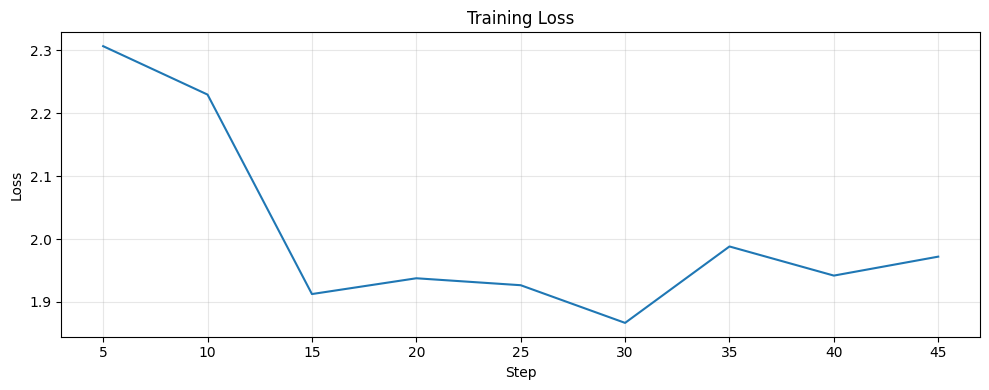

Final loss: 1.9721172332763672


In [ ]:
# ============================================================
# Plot Loss Curve
# ============================================================
import matplotlib.pyplot as plt

losses = [(e["step"], e["loss"]) for e in trainer.state.log_history if "loss" in e]
if losses:
    steps, vals = zip(*losses)
    plt.figure(figsize=(10,4))
    plt.plot(steps, vals, lw=1.5)
    plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("Final loss:", vals[-1])
else:
    print("No loss data found.")


In [ ]:
# ============================================================
# Merge & Export (reassigns `model` so inference uses merged weights)
# ============================================================
MERGE_MODEL = True

if MERGE_MODEL:
    print("⏳ Merging adapter into base model...")
    del trainer
    torch.cuda.empty_cache()

    model = model.merge_and_unload()
    model.eval()

    merged_path = os.path.join(OUTPUT_DIR, "merged_model")
    model.save_pretrained(merged_path)
    tokenizer.save_pretrained(merged_path)
    print(f"✅ Merged model saved: {merged_path}")
else:
    print("Skipped merge. Use adapter directly.")


⏳ Merging adapter into base model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Merged model saved: ./finetuned-model/merged_model


In [ ]:
# ============================================================
# (Optional) Push to Hub
# ============================================================
if PUSH_TO_HUB and HUB_MODEL_ID:
    print(f"Pushing to {HUB_MODEL_ID}...")
    model.push_to_hub(HUB_MODEL_ID, token=HF_TOKEN)
    tokenizer.push_to_hub(HUB_MODEL_ID, token=HF_TOKEN)
    print(f"✅ Pushed: https://huggingface.co/{HUB_MODEL_ID}")
else:
    print("Hub upload skipped.")


Hub upload skipped.
